In [1]:
!git clone https://github.com/InterDigitalInc/HRFAE.git
%cd HRFAE

Cloning into 'HRFAE'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 116 (delta 42), reused 92 (delta 21), pack-reused 0
Receiving objects: 100% (116/116), 2.79 MiB | 0 bytes/s, done.
Resolving deltas: 100% (42/42), done.
Checking connectivity... done.
/home/hortonbm/CS_490_Group_NotReally/pytorch/High_Res_Face_Age_Edit_Pytorch/HRFAE


In [ ]:
%cd logs/001
!./download.sh
%cd ./../..

/home/hortonbm/CS_490_Group_NotReally/pytorch/High_Res_Face_Age_Edit_Pytorch/HRFAE/logs/001
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 33 49.2M   33 16.6M    0     0   629k      0  0:01:20  0:00:27  0:00:53  651k

In [ ]:
import argparse
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import yaml

import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from torchvision import transforms, utils

from datasets import *
from nets import *
from functions import *
from trainer import *

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--config', type=str, default='001', help='path to the config file.')
parser.add_argument('--vgg_model_path', type=str, default='./models/dex_imdb_wiki.caffemodel.pt', help='pretrained age classifier')
parser.add_argument('--log_path', type=str, default='./logs/', help='log file path')
parser.add_argument('--multigpu', type=bool, default=False, help='use multiple gpus')
parser.add_argument('--checkpoint', type=str, default='', help='checkpoint file path')
parser.add_argument('--img_path', type=str, default='./test/input/', help='test image path')
parser.add_argument('--out_path', type=str, default='./test/output/', help='test output path')
parser.add_argument('--target_age', type=int, default=55, help='Age transform target, interger value between 20 and 70')
opts = parser.parse_known_args()[0]

log_dir = os.path.join(opts.log_path, opts.config) + '/'
if not os.path.exists(opts.out_path):
    os.makedirs(opts.out_path)

config = yaml.load(open('./configs/' + opts.config + '.yaml', 'r'))
img_size = (config['input_w'], config['input_h'])

# Initialize trainer
trainer = Trainer(config)
device = torch.device('cuda', 1)
trainer.to(device)

# Load pretrained model 
if opts.checkpoint:
    trainer.load_checkpoint(opts.checkpoint)
else:
    trainer.load_checkpoint(log_dir + 'checkpoint')

def preprocess(img_name):
    resize = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor()
            ])
    normalize = transforms.Normalize(mean=[0.48501961, 0.45795686, 0.40760392], std=[1,1,1])
    img_pil = Image.open(opts.img_path + img_name)
    img_np = np.array(img_pil)
    img = resize(img_pil)
    if img.size(0) == 1:
        img = torch.cat((img, img, img), dim = 0)
    img = normalize(img)
    return img

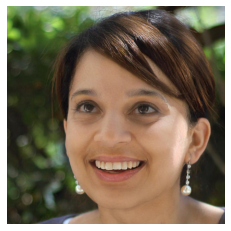

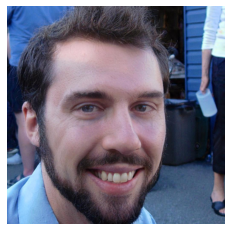

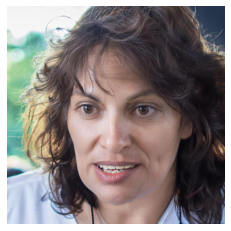

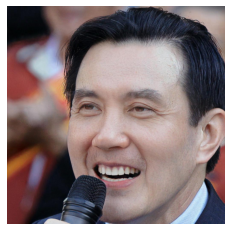

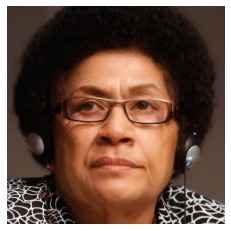

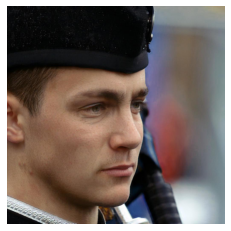

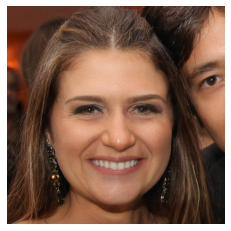

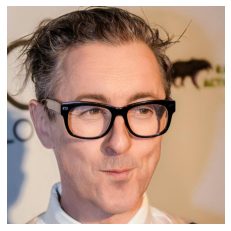

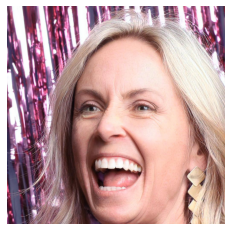

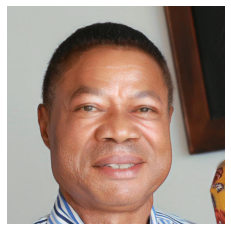

In [7]:
# Set target age
target_age = 70

# Load test image
img_list = os.listdir(opts.img_path)
img_list.sort()

with torch.no_grad():
    for img_name in img_list:
        if not img_name.endswith(('png', 'jpg', 'PNG', 'JPG')):
            print('File ignored: ' + img_name)
            continue
        image_A = preprocess(img_name)
        image_A = image_A.unsqueeze(0).to(device)

        age_modif = torch.tensor(target_age).unsqueeze(0).to(device)
        image_A_modif = trainer.test_eval(image_A, age_modif, target_age=target_age, hist_trans=True)  
        utils.save_image(clip_img(image_A_modif), opts.out_path + img_name.split('.')[0] + '_age_' + str(target_age) + '.jpg')

        # Plot manipulated image
        img_out = np.array(Image.open(opts.out_path + img_name.split('.')[0] + '_age_' + str(target_age) + '.jpg'))
        plt.axis('off')
        plt.imshow(img_out)
        plt.show() 